**NOMS I COGNOMS:** Zhipeng Lin, Zhihan Lin

**GRUP DE LABORATORI:** A

# Anàlisi exploratòria de dades i preprocessament 

L'**anàlisi exploratòria de dades** és el tractament estadístic al qual se sotmeten les mostres recollides durant un procés de recerca en qualsevol camp científic. 
Per a major rapidesa i precisió, tot el procés sol realitzar-se per mitjans informàtics, amb aplicacions específiques per al tractament estadístic.

### Aplicació a la Mineria de Dades

A la **mineria de dades**, si bé no és obligatori, és una bona pràctica analitzar les dades amb què treballarem per tal d'observar-ne les característiques principals per tal de tenir una idea de l'estructura del conjunt de dades, identificar la variable objectiu i possibles tècniques de modelatge.

**Procés bàsic**
- *Transformar les dades*: Ens serveix per saber què fer front a valors nuls, faltants o dades atípiques. A més destablir si hi ha necessitat de reduir la dimensionalitat de dades.
- *Visualitzar*: Utilitzar alguna eina per fer una representació gràfica de les dades, per exemple, R, Jupyter notebook, Google Colab, etc.
- *Analitzar i interpretar*: Analitzar i interpretar les dades a través de diferents visualitzacions.
- *Documentar*: Documentar totes les gràfiques i estadístiques generades.

Aquest procés ens és útil també en revisar la descripció de les dades per comprendre què significa cada característica.

Hi ha diverses activitats en fer una anàlisi exploratòria de dades però quant a la mineria de dades els punts clau que s'han de realitzar són:

- Descripció de l'estructura de les dades.
- Identificació de dades mancants.# ¿Com ha afectat la covid a l'ús dels taxis a Nova York? 
- Detecció de valors atípics.
- Identificació de relacions entre parells variables.

Si realitzem correctament els passos ens facilitarem la manera d'abordar aquestes dades sense deixar de banda l'objectiu o el propòsit per al qual les necessitem.

L'**objectiu d'aquesta pràctica** és aprendre com fer una explicació de dades. En aquest cas utilitzarem les dades dels **taxis grocs de la ciutat de Nova York**.

En finalitzar el notebook, haureu de ser capaços de respondre la pregunta següent:


## ¿Com ha afectat la covid a l'ús dels taxis a Nova York? 

Algunes de les preguntes que ens farem al llarg del notebook són:
- Com ha canviat la covid l'ús dels taxis a NYC?
- Quina distribució d'encàrrecs segueixen els taxis i quina distància / durada tenen?
- Quines són les zones on m'és / menys taxis s'agafen? I a on més va la gent?
- Quins horaris són els més usuals?
- Quins dies de la setmana i del mes s'utilitzen més? Possibles motius?

**Instal·lació i importació de les llibreries necessàries**

In [195]:
#Install lib

In [ ]:
# Importació de les llibreries
import pandas as pd
import numpy as np
import urllib.request
import zipfile
import os
from tqdm.notebook import tqdm
import pyarrow.parquet as pq

In [ ]:
import shapefile
from shapely.geometry import Polygon
from descartes.patch import PolygonPatch
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Variables globals
YEARS = [2019, 2020, 2021]

Primer de tot cal descarregar les dades:

https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page

In [ ]:
# Download the Trip Record Data
for year in tqdm(YEARS):
    if not os.path.exists(f'data/{year}'):
        os.makedirs(f'data/{year}', exist_ok=True)
        for month in tqdm(range(1, 13)): 
            urllib.request.urlretrieve(f'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_{year}-{month:02d}.parquet', f'data/{year}/{month:02d}.parquet')

  0%|          | 0/3 [00:00<?, ?it/s]

## 01. Neteja de dades

Per tal de tenir unes dades netes i útils, cal eliminar totes aquelles files que continguin informació corrupta:
- La recollida és després que la finalització del trajecte.
- Les dades s'importen per mes i any. Les dates són correctes?
- Viatges amb 0 passatges?
- Viatges molts llargs o molt curts?
- Pagaments negatius.

**Data Dictionary**

De totes les columnes que tenen les dades, només calen les següents:

- *tpep_pickup_datetime*: The date and time when the meter was engaged.
- *tpep_dropoff_datetime*: The date and time when the meter was disengaged. 
- *Passenger_count*: The number of passengers in the vehicle. (This is a driver-entered value)
- *Trip_distance*: The elapsed trip distance in miles reported by the taximeter.
- *PULocationID*: TLC Taxi Zone in which the taximeter was engaged
- *DOLocationID*: TLC Taxi Zone in which the taximeter was disengaged
- *Payment_type*: A numeric code signifying how the passenger paid for the trip. 
    - 1= Credit card
    - 2= Cash
    - 3= No charge
    - 4= Dispute
    - 5= Unknown
    - 6= Voided trip
- *Fare_amount*: The time-and-distance fare calculated by the meter.
- *Total_amount*: The total amount charged to passengers. Does not include cash tips.

**Observacions:**

- Per agilitzar els càlculs i reduir el temps de còmput, feu un sampleig uniforme de les dades.
- Datatime columns són to_datetime series (ajuda per buscar les funcions)

In [ ]:
def load_table(year, month):
    """
    Funció que llegeix les dades descarregades i les converteix a un DataFrame
    """
    return pq.read_table(f'data/{year}/{str(month).zfill(2)}.parquet').to_pandas()

In [ ]:
required_data = ['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance', 'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'total_amount']

# variable de limits que serveix per netejar dates
minimal_distance = 0.5 #equival 500 meters
maximal_distance = 50 #equival 50 km
minimal_passenger_count = 1
maximal_passenger_count = 9


def clean_data(data, year, month, sampling = 1000):
    """
    Funció que neteja les dades per un mes donat.
    """
    if sampling != None:
        data = data[::sampling]
    
    '''
    Les dades han de ser vàlides, per tant han de complir les condicions següents:
        1. la data de pickup ha de ser més aviat que la data de drop off
        2. els anys ha de estar entre 2019 i 2021
        3. el nombre de passatgers ha de ser més o igual que 1 ni més petit o igual que 9
        4. la distancia del viatge ha de ser més gran que 0.5km, ja que considerem que un viatge de 500 metres és massa curt
        5. la distancia del viatge ha de ser més petit que 50km, ja que considerem que és un viatge massa llarg
        6. el total de diners pagat ha de ser positiu, ja que un pagament negatiu no és vàlid

    '''
    filt1 = (data['tpep_pickup_datetime'] < data['tpep_dropoff_datetime'])
    filt2 = (pd.DatetimeIndex(data['tpep_pickup_datetime']).year == year)
    filt3 = (data['passenger_count'] >= minimal_passenger_count)
    filt4 = (data['passenger_count'] <= maximal_passenger_count)
    filt5 = (data['trip_distance'] >= minimal_distance)
    filt6 = (data['trip_distance'] <= maximal_distance)
    filt7 = (data['total_amount'] > 0) 

    # seleccionar les dades que volem
    data = data.loc[filt1 & filt2 & filt3 & filt4 & filt5 & filt6 & filt7]
    
    return(data[required_data].drop_duplicates())   
    
    

A la funció *post_processing* podeu afegir tota aquesta informació que necessiteu sobre les dades per tal de dur a terme l'exploració necessària.

In [ ]:
def post_processing(data):
    """
    Funció on implementar qualsevol tipus de postprocessament necessari.
    """
    # AQUÍ EL TEU CODI
    
    #Les dades del recollida i baixada
    data['year'] = pd.DatetimeIndex(data['tpep_pickup_datetime']).year
    data['pickup_hour'] = pd.DatetimeIndex(data['tpep_pickup_datetime']).hour
    data['pickup_day'] = pd.DatetimeIndex(data['tpep_pickup_datetime']).dayofweek
    data['pickup_week'] = pd.DatetimeIndex(data['tpep_pickup_datetime']).weekofyear
    data['pickup_month'] = pd.DatetimeIndex(data['tpep_pickup_datetime']).month
    data['pickup_dayofyear'] = pd.DatetimeIndex(data['tpep_pickup_datetime']).dayofyear
    data['dropoff_hour'] = pd.DatetimeIndex(data['tpep_dropoff_datetime']).hour
    data['dropoff_day'] = pd.DatetimeIndex(data['tpep_dropoff_datetime']).dayofweek
    data['dropoff_week'] = pd.DatetimeIndex(data['tpep_dropoff_datetime']).weekofyear
    data['dropoff_month'] = pd.DatetimeIndex(data['tpep_dropoff_datetime']).month   

    data['trip_duration'] = data['tpep_dropoff_datetime'] - data['tpep_pickup_datetime']
    data['trip_duration'] = data['trip_duration'].astype('timedelta64[s]')/3600   
    return data 

Crea un nou dataset que contingui tota la informació dels anys: 2019, 2020, 2021.

Recordeu que per tal de reduir la memòria necessària, podeu agafar un subsample de dades.

In [ ]:
df = pd.concat([clean_data(load_table(year, month), year, month) for year in tqdm(YEARS) for month in tqdm(range(1, 13), leave = False)])

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

In [ ]:
df = post_processing(df)
df.shape

C:\Users\zhiha\AppData\Local\Temp/ipykernel_9864/2605427739.py:12: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  data['pickup_week'] = pd.DatetimeIndex(data['tpep_pickup_datetime']).weekofyear
C:\Users\zhiha\AppData\Local\Temp/ipykernel_9864/2605427739.py:17: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  data['dropoff_week'] = pd.DatetimeIndex(data['tpep_dropoff_datetime']).weekofyear


(127309, 20)

In [ ]:
df.head(1)

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,total_amount,year,pickup_hour,pickup_day,pickup_week,pickup_month,pickup_dayofyear,dropoff_hour,dropoff_day,dropoff_week,dropoff_month,trip_duration
0,2019-01-01 00:46:40,2019-01-01 00:53:20,1.0,1.5,151,239,1,7.0,9.95,2019,0,1,1,1,1,0,1,1,1,0.111111


## 02. Visualitzacions per anys

### Número total sobre quantitat de viatges

Podem respondre directament la pregunta: **¿Ha incrementat / disminuït la covid la quantitat de viatges fets amb taxis?**

Per respondre aquesta pregunta creu una figura de barres on es visualitzin la quantitat de viatges per any.

In [ ]:
def bar_plot(df, column, xlabel, ylabel, title):
    """
    Funció que crea una figura de barres a partir del dataframe i la columna que conté la informació
    """

    # contar els viatges dels 3 anys i ordenar els indexos
    dg = df[column].value_counts()
    dg = dg.sort_index()
    dg.plot.bar(xlabel =xlabel, ylabel = ylabel, rot=0, title=title)

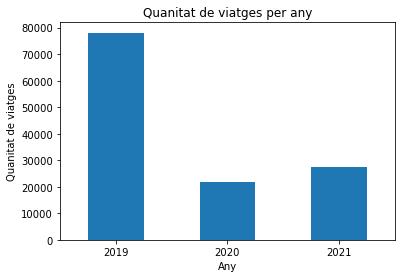

In [ ]:
bar_plot(df, 'year', 'Any', 'Quanitat de viatges', 'Quanitat de viatges per any')

**Pregunta: És el comportament que esperàveu? Per què?**

> ANSWER: Si el comortament és el que esperàvem, amb el Covid, els nombres de passatgers disminueixen.  

Ara, visualitzarem **quants passatgers hi ha per taxi i per any**.

Crea una figura amb tres subfigures (una per any) on es pugui veure el recompte de passatgers per any.

Després repetiu el mateix gràfic visualitzant el % (utilitzeu el paràmetre *norm*).

In [ ]:
def passengers_taxi_year(df, ylim, xlabel, ylabel, title, norm = False):
    """
    Funció que visualitza quants passatgers hi ha per taxi i per any
    """

    # la suma del nombre de passatgers que hi ha cada any i fer reset index per poder manipular les columnes
    df = df.groupby(['year','passenger_count']).agg(total_passengers=('passenger_count', 'sum')).reset_index()
    fig, axs = plt.subplots(1,3,figsize = (20,15))

    # representa gràfics per cada any
    for y in YEARS:

        # seleccionar els viatges de l'any corresponent
        dg = df[df['year'] == y]

        # passar a tant per cent si norm és TRUE
        if norm:
            passengers_taxi_year_total = dg['total_passengers'].sum()

            # fer una copia de la taula dg i utilitzem aquesta copia, perquè sinó sortirà un warning
            dg_copy = dg.copy()
            dg_copy['total_passengers'] = dg['total_passengers'] / passengers_taxi_year_total
            dg_copy['total_passengers'].plot(ax=axs[y-2019],xlabel=xlabel,ylabel=ylabel,title=title + f' {y}',kind='bar')
            axs[y-2019].set_xticklabels(dg['passenger_count'].unique(),rotation='horizontal')
            plt.ylim(ylim)
            continue

        # representar al gràfic la columna del passenger total
        dg['total_passengers'].plot(ax=axs[y-2019],xlabel=xlabel,ylabel=ylabel,title=title + f' {y}',kind='bar')
        axs[y-2019].set_xticklabels(dg['passenger_count'].unique(),rotation='horizontal')
        plt.ylim(ylim)
    plt.show()


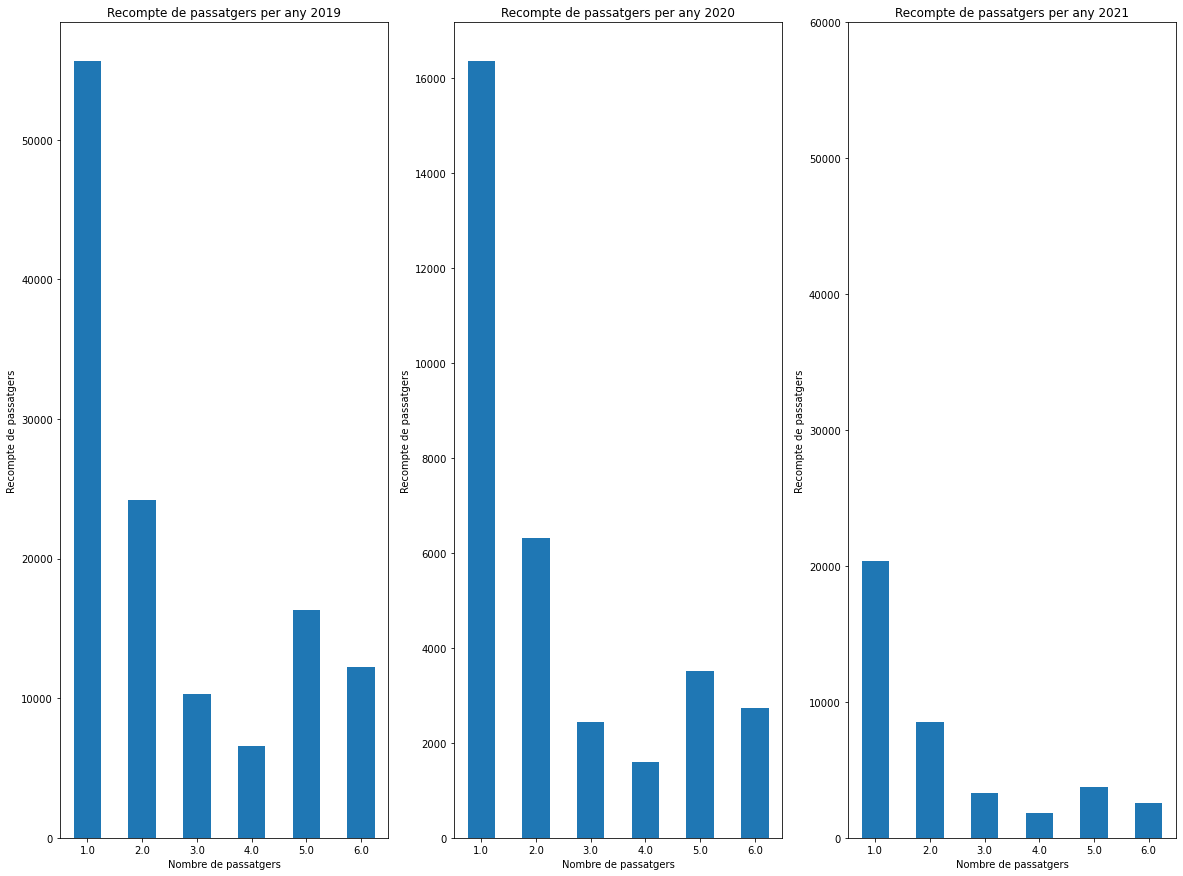

In [ ]:
passengers_taxi_year(df, (0, 60000), 'Nombre de passatgers', 'Recompte de passatgers', 'Recompte de passatgers per any')

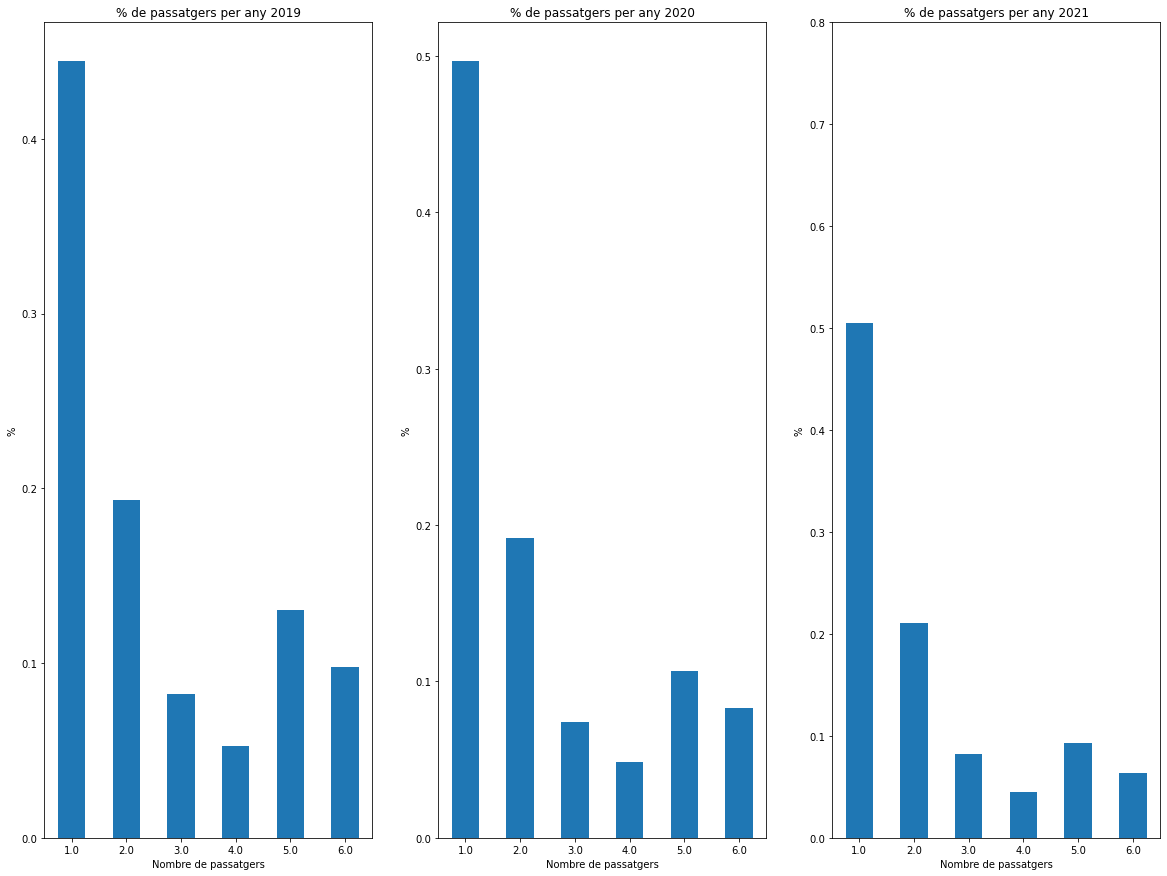

In [ ]:
passengers_taxi_year(df, (0, 0.8), 'Nombre de passatgers', '%', '% de passatgers per any', norm = True)

A la figura anterior hem visualitzat cada any per separat. Per tal que la visualització sigui més ràpida i simple d'interpretar, uniu tota la informació en un gràfic.

Després repetiu el mateix gràfic visualitzant el % (utilitzeu el paràmetre *norm*).

In [ ]:
from collections import defaultdict
def passengers_taxi(df, xlabel, ylabel, norm = False):
    """
    Funció que visualitza quants passatgers hi ha per taxi
    """

    # guardar els indexos ordenat
    dct = defaultdict()
    index = np.sort(df['passenger_count'].unique())
    
    # representar per cada any
    for y in YEARS:
        
        # condició de selecció de l'any corresponent i agafar els viatges que necessitem
        fit = (df['year']==y)
        dg = df.loc[fit]['passenger_count']

        # contar els viatges i ordenar els indexos
        dg = dg.value_counts().sort_index()

        # representar en tant per cent si norm és TRUE
        if norm:
            count = dg.sum()
            dg = dg/count

        # guardar les dades de cada any
        dct[f'{y}'] = dg.to_list()

    # representar la gràfica de les dades de les 3 anys
    dg = pd.DataFrame(dct,index=index)
    dg.plot.bar(rot=0)

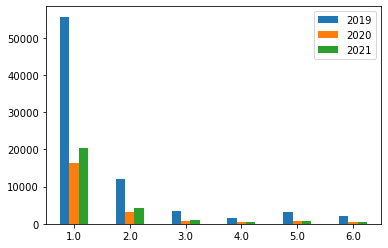

In [ ]:
passengers_taxi(df, 'Passenger Count', 'Amount')

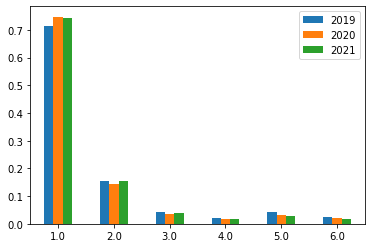

In [ ]:
passengers_taxi(df, 'Passenger Count', 'Amount', norm = True)

**Pregunta: Quin impacte heu vist sobre les dades? Creieu que la covid va tenir molt impacte?**

> ANSWER => Els passatgers en taxi a Nova York han baixat significativament a causa del Covid, el nombre de passatgers comptades el 2019 és practicament el doble que la suma dels passatgers del 2020 i el 2021 .

## 03. Quantitat de viatges

Fins ara hem vist la quantitat de viatges que hi ha hagut en els anys estudiats.

Anem a estudiar quins canvis es poden veure si agreguem les dades per hores, dies de la setmana, setmana de l'any i mes.

Aquests gràfics han de ser de línies discontínues i marcar amb una rodona o creu allà on està el valor

In [ ]:
from collections import defaultdict
def visualize_trips(df, columns, title, xlabel, ylabel):
    """
    Funció que visualitza els viatges per diferents agregacions de dades
    """

    # representar la gràfica de pickup_hour i dropoff_hour
    for column in columns:

         # guardar els indexos ordenat
        index = np.sort(df[column].unique())
        dct = defaultdict()

        # agafem dades per any
        for y in YEARS:

            # contar el total de viatges d'aquest any i guarda en un diccionari
            lista = df.loc[df['year']==y,column].value_counts().sort_index()
            lista = lista.reindex(index)
            lista = lista.to_list()
            dct[f'{y}'] = lista
        
        # representar a la gràfica
        dg = pd.DataFrame(dct,index=index)
        dg.plot.line(rot=0, style='x:', title=title)
            


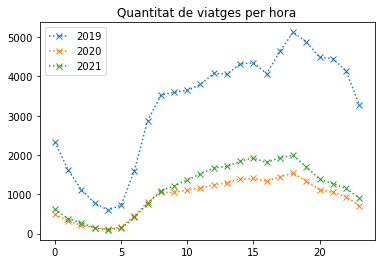

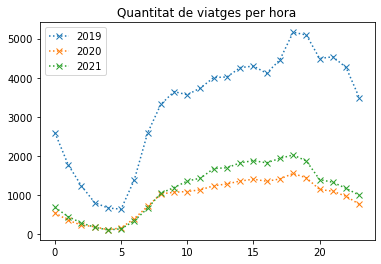

In [ ]:
visualize_trips(df, ['pickup_hour', 'dropoff_hour'], title = 'Quantitat de viatges per hora', xlabel = 'Hora del dia', ylabel = 'Quanitat')

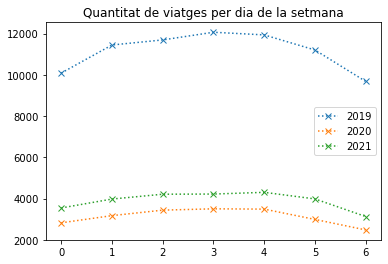

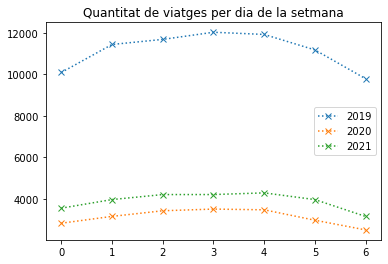

In [ ]:
visualize_trips(df,['pickup_day', 'dropoff_day'], title = 'Quantitat de viatges per dia de la setmana', xlabel = 'Dia de la setmana', ylabel = 'Quanitat')

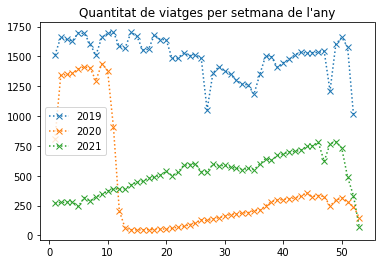

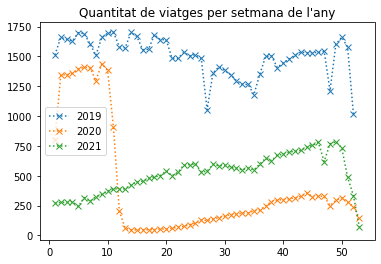

In [ ]:
visualize_trips(df,['pickup_week', 'dropoff_week'], title = 'Quantitat de viatges per setmana de l\'any', xlabel = 'Setmana de l\'any', ylabel = 'Quanitat')

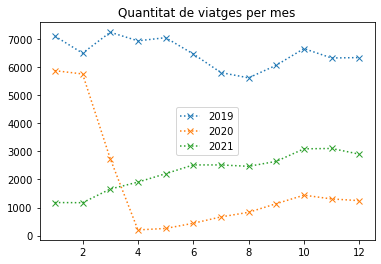

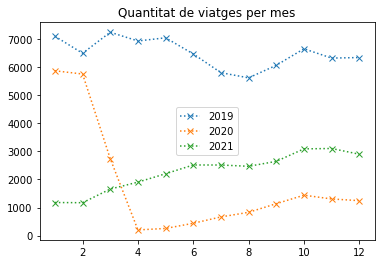

In [ ]:
visualize_trips(df,['pickup_month', 'dropoff_month'], title = 'Quantitat de viatges per mes', xlabel = 'Mes de l\'any', ylabel = 'Quanitat')

**Pregunta: Quins comportaments veieu en cada cas? Quin creieu que és el motiu?**

> ANSWER
:   La comportament que veiem:
- Per hora: hi ha més quantitat de viatges en el migdia, ja que de bon matí o en la nit no hi ha tanta gent despertada.
- Per dia de la setmana: hi ha més quantitat de viatges en dimecres i dijous i molt menys quantitat de viatges en cap de la setmana perquè la gent descansen.
- Per setmana de l'any: hi ha més quantitat de viatges en el principi de l'any i es van disminuint fins que en els ultimes setmanes de l'any la quantitat de viatges es la més petita, perquè crec és quan produeix la pandèmia.
- Per mes de l'any: hi ha més quantitat de viatges en el principi de l'any, però després es va disminuir molt acausa del covid.

## 04. Relació distancia - temps i velocitat

A les dades tenim la distància que ha recorregut el taxi en cada viatge i de la informació temporal podem extreure també la duració d'aquest.


Intentarem esbrinar com la covid va afectar les distàncies i les durades dels viatges juntament amb la velocitat dels taxis.

Creieu que la densitat de trànsit va variar?

### Histogrames

Per començar visualitza els **histogrames** de distància i durada per any.

Pots fer servir la funció *plt.hist()* o *plt.bar()*.

In [ ]:
def visualize_histograms(df, column, title, xlabel, ylabel, xlim):
    """
    Funció que crea un histograma a partir de la informació que conté la columna del dataframe
    """

    # representar la gràfica en 1 figura amb 3 subfigures
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 8)) 

    # representar la gràfica per cada any
    for i in YEARS:

        # selecciona les dades d'aquest any
        new_df = df.loc[df['year'] == i, column]

        # representar la histograma
        new_df.hist(bins=75, ax=axs[i-2019])
        axs[i-2019].set_title(title + f" ({i})")
        axs[i-2019].set_xlabel(xlabel)
        axs[i-2019].set_ylabel(ylabel)
        axs[i-2019].set_xlim(xlim)
    
    plt.show()



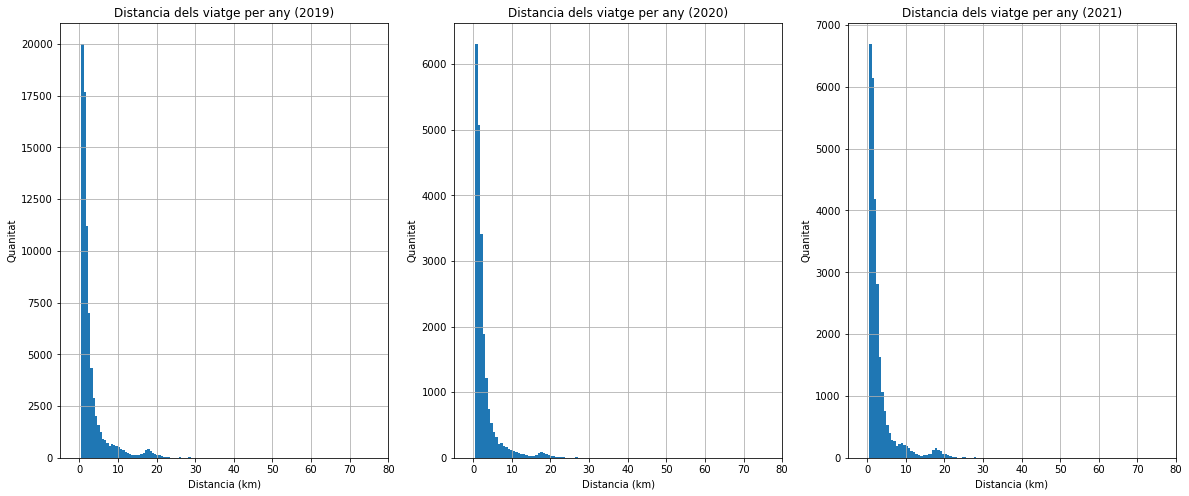

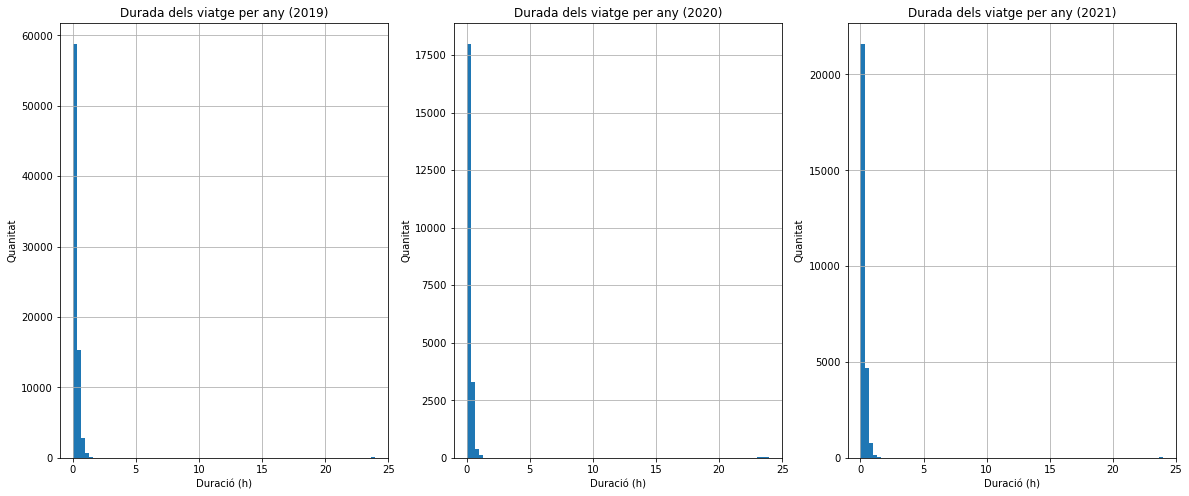

In [ ]:
visualize_histograms(df, 'trip_distance', title = 'Distancia dels viatge per any', 
                     xlabel = 'Distancia (km)', ylabel = 'Quanitat', xlim = (-5, 80))

visualize_histograms(df, 'trip_duration', title = 'Durada dels viatge per any', 
                     xlabel = 'Duració (h)', ylabel = 'Quanitat', xlim = (-1, 25) )

**PREGUNTES:** 

* Com creieu que la covid va afectar les distàncies i durades dels viatges?

* I a la velocitat dels taxis?

> ANSWER:  Podem veure que en els viatges de curta durada la covid no s'afecta gaire, en canvi, en les viatges de distància mitjana la covid fa que el nombre de viatges es disminueixen. En en cas de durades del viatges passa el mateix, no es veu l'afectació del covid en curta durada sinó afecta més en
llargues durades. En el cas de la velocitat dels taxis, no va afectar gaire, només que en el 2020 la desviació estàndard és la meitat que 2021. La velocitat mitjana és més o meny igual en els 3 anys.

### Gràfic de dispersió i correlació

Crea gràfics de dispersió per il·lustrar la relació entre la durada i la distància dels viatges.

Es possible que les dades continguin mostres fora la distribució (outliers). En aquest cas, omet aquestes dades i torna a visualitzar el grafic.

Per veure si existeix alguna correlació, es interesant que utilitzeu la funció *sns.regplot()*.

In [ ]:
def scatter_plot(df, x_value, y_value, xlabel, ylabel, find_outliers = False):
    """
    Funció que mostra un scatter plot donades dues dades
    """

    # crear una funció que busca els limits de outliers
    def findOutliersLimits(df, value):

        # the critery we use to identify outliers is: 
        # fall outside of 3 standard deviations
        meanValue = df[value].mean()
        stdValue = df[value].std()
        minLimit, maxLimit = (meanValue - 3*stdValue), (meanValue + 3*stdValue)
        return (minLimit,maxLimit)

    if find_outliers:

        # trobar els punts que està entre els intervals, ja que no volem els outliers
        x = findOutliersLimits(df, x_value)
        y = findOutliersLimits(df, y_value)
        df = df[(df[x_value] > x[0]) & (df[x_value] < x[1]) & (df[y_value] > y[0]) & (df[y_value] < y[1])]

    # representar la gràfica de dispersió
    sns.regplot(data=df[[x_value,y_value]], x=x_value,y=y_value,scatter=True)

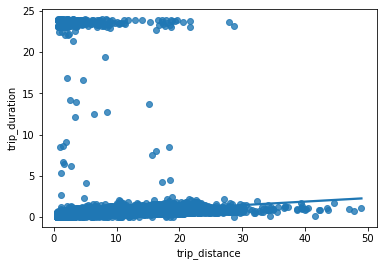

In [ ]:
scatter_plot(df, 'trip_distance', 'trip_duration', 'Distancia (km)', 'Temps (h)')

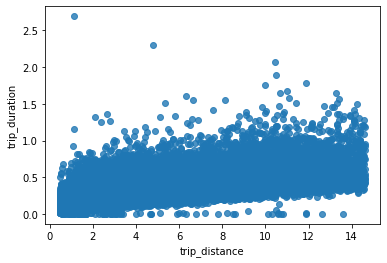

In [ ]:
scatter_plot(df, 'trip_distance', 'trip_duration', 'Distancia (km)', 'Temps (h)', True)

**Pregunta: Pots veure alguna relació? Pots calcular la correlació entre les dades per treure més informació?**

> ANSWER: La majoria de viatges són de curta durada i les distancies en general també són curtes.

Tal com fèiem a l'apartat 3, visualitzeu les dades temporals i de distància a partir de les setmanes, i mesos de l'any.

In [ ]:
def visualize_per_period(df, column_data, columns, xlabel, ylabel, title):
    """
    Funció que visualitza la distància / duració dels trajectes en un temps a determinar
    """

    # representar el gràfic de pickup_week i el dropoff_week
    for column in columns:

        # obtenir els indexos
        index = np.sort(df[column].unique())
        dct = defaultdict()

        # guardar les dades de cada any
        for y in YEARS:

            # seleccionar l'any corresponent, calcular la mitjana i guardar en un diccionari
            dg = df.loc[df['year']==y]
            lista = dg.groupby(column)[column_data].mean()
            dct[f'{y}'] = lista
        
        # representar les dades de les 3 anys
        dg = pd.DataFrame(dct, index=index)
        dg.plot.line(rot=0, style='x:', title=title + f' ({column})', xlabel=xlabel, ylabel=ylabel)        

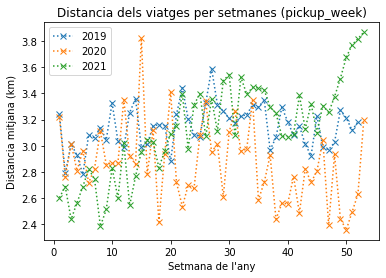

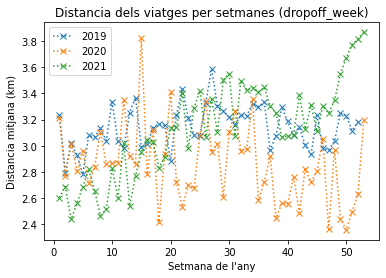

In [ ]:
visualize_per_period(df, 'trip_distance', columns = ['pickup_week', 'dropoff_week'],
                    xlabel = 'Setmana de l\'any', ylabel = 'Distancia mitjana (km)', title = 'Distancia dels viatges per setmanes')

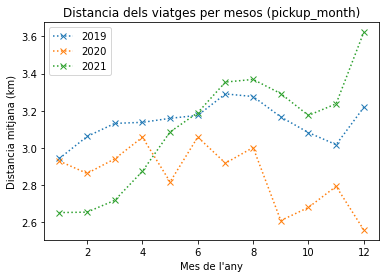

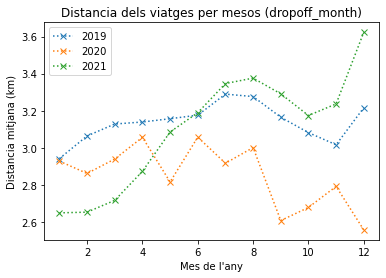

In [ ]:
visualize_per_period(df, 'trip_distance', columns = ['pickup_month', 'dropoff_month'],
                     xlabel = 'Mes de l\'any', ylabel = 'Distancia mitjana (km)', title = 'Distancia dels viatges per mesos')

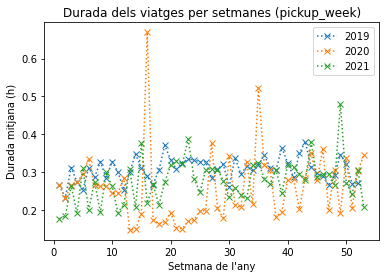

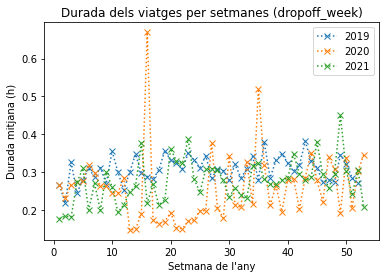

In [ ]:
visualize_per_period(df, 'trip_duration', columns = ['pickup_week', 'dropoff_week'],
                     xlabel = 'Setmana de l\'any', ylabel = 'Durada mitjana (h)', title = 'Durada dels viatges per setmanes')

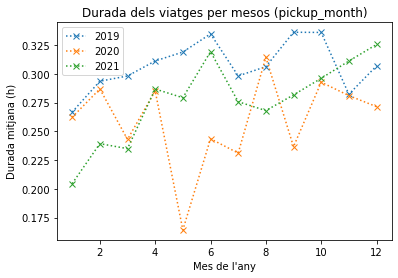

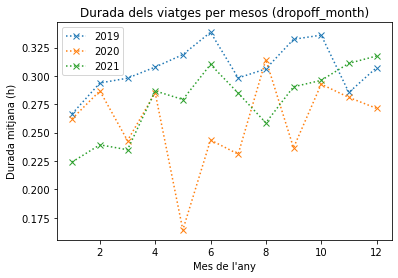

In [ ]:
visualize_per_period(df, 'trip_duration', columns = ['pickup_month', 'dropoff_month'],
                     xlabel = 'Mes de l\'any', ylabel = 'Durada mitjana (h)', title = 'Durada dels viatges per mesos')

**Pregunta: Hi ha algun comportament estrany a part de la covid? Per què pot ser causat?**
    
> ANSWER: Hi ha una gran decrementació de durada en l'any 2020 i al mes de maig. Pot estar causat perquè és el periode de la iniciació de la pandèmia.

Fins ara hem mostrat les dades de manera agregada.

Per tal de visualitzar-ho de manera global, utilitzarem la funció *plt.imshow()* que visualitza imatges i, per tant, matrius.

Implementa una funció que visualitzi per any:

- un mapa de calor que indiqui a quina hora del dia hi ha viatges més llargs durant l'any.
- un mapa de calor que indiqui a quina hora del dia hi ha viatges més llargs durant la setmana.

In [ ]:
df

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,total_amount,year,pickup_hour,pickup_day,pickup_week,pickup_month,pickup_dayofyear,dropoff_hour,dropoff_day,dropoff_week,dropoff_month,trip_duration
0,2019-01-01 00:46:40,2019-01-01 00:53:20,1.0,1.50,151,239,1,7.0,9.95,2019,0,1,1,1,1,0,1,1,1,0.111111
1000,2019-01-01 00:53:09,2019-01-01 01:01:16,1.0,1.91,148,137,2,8.5,9.80,2019,0,1,1,1,1,1,1,1,1,0.135278
2000,2019-01-01 00:50:22,2019-01-01 01:19:44,2.0,7.70,264,264,1,26.0,31.30,2019,0,1,1,1,1,1,1,1,1,0.489444
3000,2019-01-01 00:54:46,2019-01-01 01:03:13,1.0,1.40,249,164,1,7.5,11.40,2019,0,1,1,1,1,1,1,1,1,0.140833
4000,2019-01-01 00:09:29,2019-01-01 00:12:29,2.0,0.67,162,137,2,4.0,5.30,2019,0,1,1,1,1,0,1,1,1,0.050000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3107000,2021-12-31 22:02:53,2022-01-01 21:23:40,1.0,1.05,114,234,2,6.0,9.80,2021,22,4,52,12,365,21,5,52,1,23.346389
3108000,2021-12-31 22:45:36,2021-12-31 22:55:16,1.0,1.64,211,158,2,9.0,12.80,2021,22,4,52,12,365,22,4,52,12,0.161111
3109000,2021-12-31 22:55:29,2021-12-31 23:05:10,1.0,1.49,79,164,2,8.0,11.80,2021,22,4,52,12,365,23,4,52,12,0.161389
3110000,2021-12-31 23:26:04,2021-12-31 23:29:32,5.0,0.90,263,236,1,5.0,11.00,2021,23,4,52,12,365,23,4,52,12,0.057778


In [ ]:
def heatmap(df, group, column_data, xlabel, ylabel, columns = None):
    """
    Funció que agrega les dades de manera adient per visualitzar un mapa de calor
    """

    # agrupar les dades per any pickup_day i hores i contar el nombre de viatges a cada part.
    df = df.groupby(['year',group[1],group[0],column_data]).count().sort_values(by = [group[1],group[0]]).reset_index()

    # només necessitem aquest part de dades
    df = df[['year',group[0],group[1],column_data]]

    fig, ax = plt.subplots(nrows=1,ncols=3, figsize=(30,30))

    # representar 3 gràfics per cada any
    for y in YEARS:
        
        # agafar les dades d'aquest any
        new_df = df[df['year'] == y]

        # crear la matriu per representar heatmap
        heatmap = pd.pivot_table(new_df,values = column_data,index=[group[0]],columns=group[1])


        # if columns != None, vol dir que volem mostrar per dies de la setmana i invertim la matriu, ja que els parametres xlabel i ylabel també està invertit
        if columns:
            heatmap = heatmap.T
            ax[y-2019].set_yticklabels(columns)
        
        # representar el heatmap 
        ax[y-2019].set_xlabel(xlabel)
        ax[y-2019].set_ylabel(ylabel)
        ax[y-2019].imshow(heatmap)
    plt.show()


    

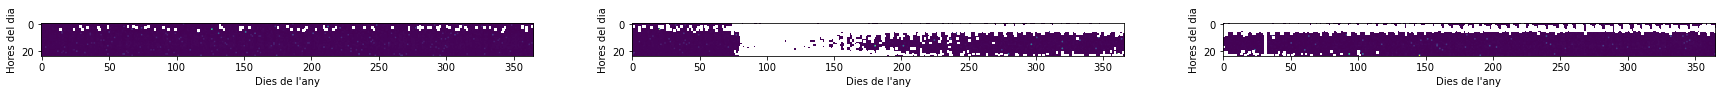

In [ ]:
heatmap(df, ['pickup_hour', 'pickup_dayofyear'], 'trip_duration', 'Dies de l\'any', 'Hores del dia')

C:\Users\zhiha\AppData\Local\Temp/ipykernel_9864/1586206555.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[y-2019].set_yticklabels(columns)


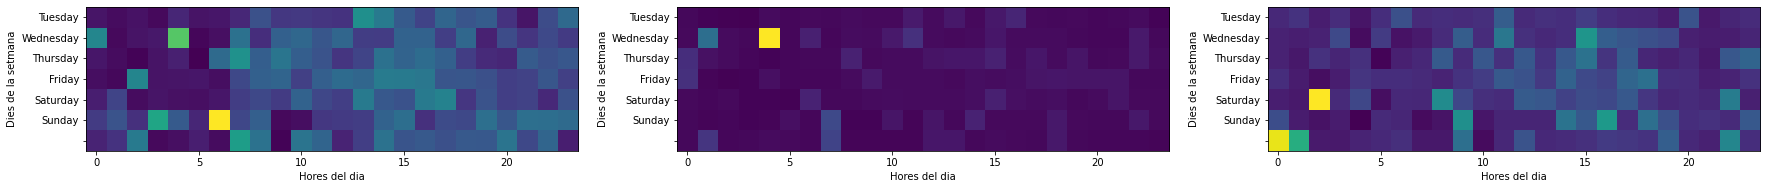

In [ ]:
heatmap(df, ['pickup_hour', 'pickup_day'], 'trip_duration', 'Hores del dia', 'Dies de la setmana', ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

Repeteix els gràfics anteriors visualitzant la distancia.

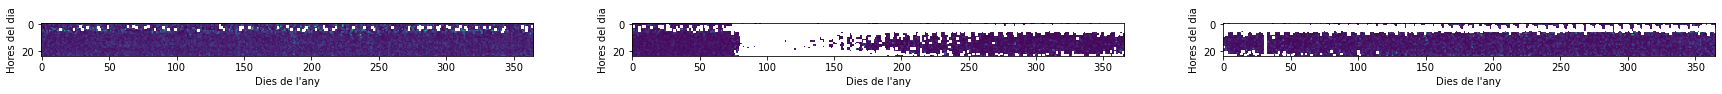

In [ ]:
heatmap(df, ['pickup_hour', 'pickup_dayofyear'], 'trip_distance', 'Dies de l\'any', 'Hores del dia')

C:\Users\zhiha\AppData\Local\Temp/ipykernel_9864/1586206555.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[y-2019].set_yticklabels(columns)


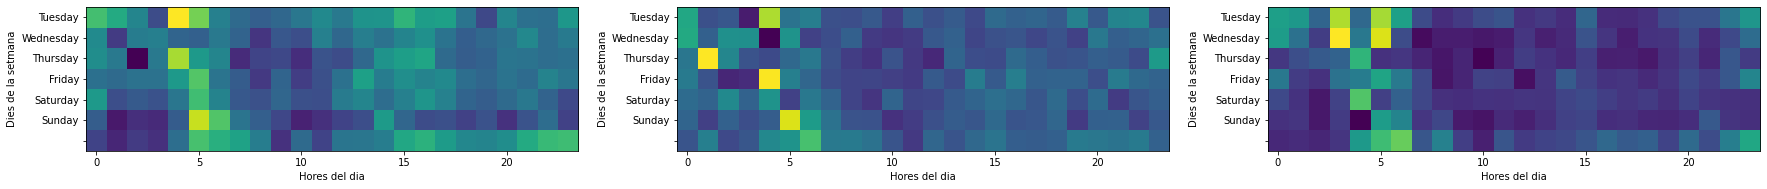

In [ ]:
heatmap(df, ['pickup_hour', 'pickup_day'], 'trip_distance', 'Hores del dia', 'Dies de la setmana', ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

In [ ]:
df

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,total_amount,year,pickup_hour,pickup_day,pickup_week,pickup_month,pickup_dayofyear,dropoff_hour,dropoff_day,dropoff_week,dropoff_month,trip_duration
0,2019-01-01 00:46:40,2019-01-01 00:53:20,1.0,1.50,151,239,1,7.0,9.95,2019,0,1,1,1,1,0,1,1,1,0.111111
1000,2019-01-01 00:53:09,2019-01-01 01:01:16,1.0,1.91,148,137,2,8.5,9.80,2019,0,1,1,1,1,1,1,1,1,0.135278
2000,2019-01-01 00:50:22,2019-01-01 01:19:44,2.0,7.70,264,264,1,26.0,31.30,2019,0,1,1,1,1,1,1,1,1,0.489444
3000,2019-01-01 00:54:46,2019-01-01 01:03:13,1.0,1.40,249,164,1,7.5,11.40,2019,0,1,1,1,1,1,1,1,1,0.140833
4000,2019-01-01 00:09:29,2019-01-01 00:12:29,2.0,0.67,162,137,2,4.0,5.30,2019,0,1,1,1,1,0,1,1,1,0.050000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3107000,2021-12-31 22:02:53,2022-01-01 21:23:40,1.0,1.05,114,234,2,6.0,9.80,2021,22,4,52,12,365,21,5,52,1,23.346389
3108000,2021-12-31 22:45:36,2021-12-31 22:55:16,1.0,1.64,211,158,2,9.0,12.80,2021,22,4,52,12,365,22,4,52,12,0.161111
3109000,2021-12-31 22:55:29,2021-12-31 23:05:10,1.0,1.49,79,164,2,8.0,11.80,2021,22,4,52,12,365,23,4,52,12,0.161389
3110000,2021-12-31 23:26:04,2021-12-31 23:29:32,5.0,0.90,263,236,1,5.0,11.00,2021,23,4,52,12,365,23,4,52,12,0.057778


Per últim, visualitza la velocitat mitjana a les diferents hores del dia durant la setmana.

In [ ]:
def speed_heatmap(df, group, xlabel, ylabel, columns = None):
    """
    Funció que agrega les dades de manera adient per visualitzar la velocitat un mapa de calor
    """
    # calcular la velocitat de cada viatge en km/h
    df['speed'] = df['trip_distance'] / df['trip_duration'] 

    # agrupar les dades per any, dies de setmana, hores del dia i la velocitat. Ordernar els valors i resetear els index per poder agafar les columnes
    df = df.groupby(['year',group[1],group[0],'speed']).count().sort_values(by = [group[1],group[0]]).reset_index()

    # només volem els columnes que necessitem: any, dies de setmana, hores del dia i la velocitat.
    df = df[['year',group[0],group[1],'speed']]

    # crear una figura amb 3 subfigures per representar heatmap de cada any
    fig, ax = plt.subplots(nrows=1,ncols=3, figsize=(30,30))
    for y in YEARS:
        
        new_df = df[df['year'] == y]
        heatmap = pd.pivot_table(new_df,values = 'speed',index=[group[0]],columns=group[1])


        # if columns != None, vol dir que volem mostrar per dies de la setmana i invertim la matriu, ja que els parametres xlabel i ylabel també està invertit
        if columns:
            heatmap = heatmap.T
            ax[y-2019].set_yticklabels(columns)

        # representar el heatmap
        ax[y-2019].set_xlabel(xlabel)
        ax[y-2019].set_ylabel(ylabel)
        ax[y-2019].imshow(heatmap)
    
    plt.show()
    

C:\Users\zhiha\AppData\Local\Temp/ipykernel_9864/1162642140.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[y-2019].set_yticklabels(columns)


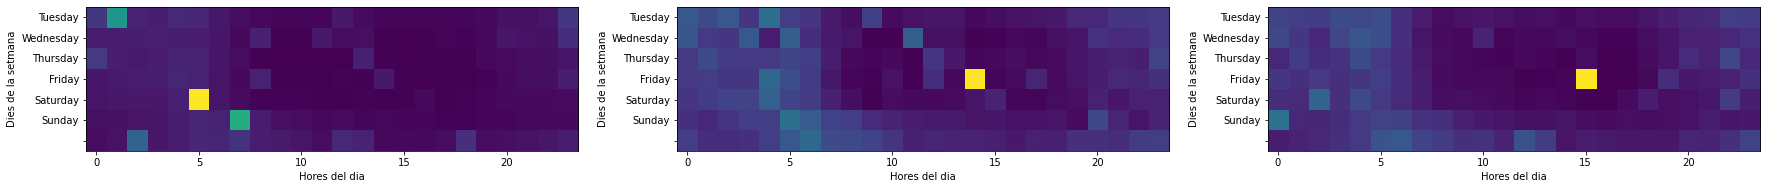

In [ ]:
speed_heatmap(df, ['pickup_hour', 'pickup_day'], 'Hores del dia', 'Dies de la setmana', ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

**Pregunta: Quines conclusions treieu dels mapes de calor?**
    
> ANSWER: En els anys 2020 i 2021, que està al periode de pandèmia, la duració i la distancia del viatge serà molt més menor que l'any 2019 que no hi ha la covid.

## 05. Visualitzem les localitzacions dels viatges

In [ ]:
df.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,total_amount,year,...,pickup_day,pickup_week,pickup_month,pickup_dayofyear,dropoff_hour,dropoff_day,dropoff_week,dropoff_month,trip_duration,speed
0,2019-01-01 00:46:40,2019-01-01 00:53:20,1.0,1.50,151,239,1,7.0,9.95,2019,...,1,1,1,1,0,1,1,1,0.111111,13.500000
1000,2019-01-01 00:53:09,2019-01-01 01:01:16,1.0,1.91,148,137,2,8.5,9.80,2019,...,1,1,1,1,1,1,1,1,0.135278,14.119097
2000,2019-01-01 00:50:22,2019-01-01 01:19:44,2.0,7.70,264,264,1,26.0,31.30,2019,...,1,1,1,1,1,1,1,1,0.489444,15.732123
3000,2019-01-01 00:54:46,2019-01-01 01:03:13,1.0,1.40,249,164,1,7.5,11.40,2019,...,1,1,1,1,1,1,1,1,0.140833,9.940828
4000,2019-01-01 00:09:29,2019-01-01 00:12:29,2.0,0.67,162,137,2,4.0,5.30,2019,...,1,1,1,1,0,1,1,1,0.050000,13.400000


Només tenim la ID d'una localització, per tant, necessitem aconseguir la latitud i la longitud.

La mateixa pàgina dels taxis ens dóna el fitxer *taxi_zones.zip*, però primer cal que convertim les dades de coordenades amb format WGS84.

Podem utilitzar aquesta web: https://mygeodata.cloud/

In [ ]:
from utils import get_lat_lon, draw_region_map, draw_zone_map

In [ ]:
sf = shapefile.Reader('data/geodata/taxi_zones.shp')
fields_name = [field[0] for field in sf.fields[1:]]
shp_dic = dict(zip(fields_name, list(range(len(fields_name)))))
attributes = sf.records()
shp_attr = [dict(zip(fields_name, attr)) for attr in attributes]

In [ ]:
df_loc = pd.DataFrame(shp_attr).join(get_lat_lon(sf, shp_dic).set_index("LocationID"), on="LocationID")
df_loc.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,longitude,latitude
0,1,0.116357,0.000782,Newark Airport,1,EWR,-74.171533,40.689483
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,-73.822478,40.610824
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,-73.844953,40.865747
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,-73.977725,40.724137
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,-74.187558,40.550664


c:\Users\zhiha\anaconda3\lib\site-packages\descartes\patch.py:63: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  concatenate([asarray(t.exterior)[:, :2]] +


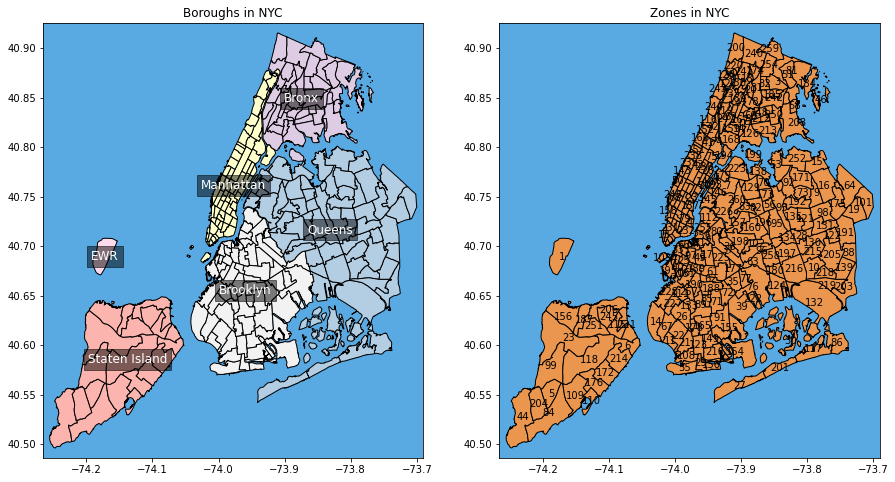

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,8))
ax = plt.subplot(1, 2, 1)
ax.set_title("Boroughs in NYC")
draw_region_map(ax, sf, shp_dic)
ax = plt.subplot(1, 2, 2)
ax.set_title("Zones in NYC")
draw_zone_map(ax, sf, shp_dic)

Ara teniu dos dataframe que necessitem unir. Utilitza la funció *merge* per afegir la longitud i latitud al dataframe *df*:

In [ ]:
# AQUÍ EL TEU CODI

merge = pd.merge(df,df_loc, left_on='PULocationID', right_on='LocationID')

In [ ]:
merge.shape

(126309, 29)

## 06. ¿Quines zones tenen més recollides i quines zones tenen més entregues?

En aquest apartat volem conèixer i visualitzar les zones on els taxis són més utilitzats.

El primer pas és ordenar i guardar en una variable els llocs més comuns en la recollida i el destí.

Printa els 5 llocs més freqüents per any en cada cas.

In [ ]:
merge.head()
merge

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,total_amount,year,...,trip_duration,speed,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,longitude,latitude
0,2019-01-01 00:46:40,2019-01-01 00:53:20,1.0,1.50,151,239,1,7.0,9.95,2019,...,0.111111,13.500000,151,0.054890,0.000129,Manhattan Valley,151,Manhattan,-73.968222,40.797859
1,2019-01-01 01:13:52,2019-01-01 01:23:56,1.0,1.80,151,236,2,9.0,10.30,2019,...,0.167778,10.728477,151,0.054890,0.000129,Manhattan Valley,151,Manhattan,-73.968222,40.797859
2,2019-01-01 11:50:47,2019-01-01 11:59:38,1.0,1.76,151,142,2,8.5,9.30,2019,...,0.147500,11.932203,151,0.054890,0.000129,Manhattan Valley,151,Manhattan,-73.968222,40.797859
3,2019-01-01 14:39:57,2019-01-01 14:47:33,6.0,1.57,151,41,2,8.0,8.80,2019,...,0.126667,12.394737,151,0.054890,0.000129,Manhattan Valley,151,Manhattan,-73.968222,40.797859
4,2019-01-01 17:23:52,2019-01-01 17:28:16,1.0,0.80,151,238,1,5.5,7.25,2019,...,0.073333,10.909091,151,0.054890,0.000129,Manhattan Valley,151,Manhattan,-73.968222,40.797859
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126304,2020-11-11 01:15:29,2020-11-11 02:08:22,1.0,42.33,86,44,1,111.5,127.79,2020,...,0.881389,48.026473,86,0.134245,0.000623,Far Rockaway,86,Queens,-73.755904,40.602582
126305,2021-12-30 19:43:14,2021-12-30 20:41:34,1.0,10.60,86,28,1,31.2,32.00,2021,...,0.972222,10.902857,86,0.134245,0.000623,Far Rockaway,86,Queens,-73.755904,40.602582
126306,2021-01-14 06:40:36,2021-01-14 07:39:29,1.0,34.89,99,95,1,96.0,99.55,2021,...,0.981389,35.551656,99,0.183371,0.001210,Freshkills Park,99,Staten Island,-74.188371,40.579422
126307,2021-09-27 23:49:15,2021-09-28 00:08:02,1.0,11.07,183,64,1,32.0,33.30,2021,...,0.313056,35.361136,183,0.039826,0.000095,Pelham Bay,183,Bronx,-73.831501,40.849546


In [ ]:
# Recollida
# AQUÍ EL TEU CODI
# crear una columna temporal que contar els viatges de cada PULocationID, ordena els valors ascendent
df['new'] = df['PULocationID'].map(merge['PULocationID'].value_counts())
top_pu = df.sort_values(['new','PULocationID'], ascending=[False, True]).drop('new', axis=1)
df = df.drop('new',axis=1)

# Destí
# AQUÍ EL TEU CODI
# crear una columna temporal que contar els viatges de cada DOLocationID, ordena els valors ascendent
df['new'] = df['DOLocationID'].map(merge['DOLocationID'].value_counts())
top_do = df.sort_values(['new','DOLocationID'], ascending=[False, True]).drop('new', axis=1)
df = df.drop('new',axis=1)


In [ ]:
n_top = 5
def show_top_n(df, column, df_loc, n_top = n_top):
    """
    Funció que mostra els llocs més usuals per any
    """

    # ajuntar la taula de df i df_loc
    new_df = pd.merge(df,df_loc, left_on=column, right_on='LocationID')

    # agrupar la nova taula en any i zones i contar el nombre de viatges i finalment mostra les 5 zones amb més viatges
    new_df = new_df.groupby(['year','borough']).count()[column].groupby('year', group_keys=False).nlargest(n_top)

    print(new_df)

In [ ]:
show_top_n(top_pu, 'PULocationID', df_loc)

year  borough      
2019  Manhattan        71069
      Queens            5386
      Brooklyn           866
      Bronx              111
      Staten Island        4
2020  Manhattan        20389
      Queens            1143
      Brooklyn           159
      Bronx               32
      Staten Island        3
2021  Manhattan        25149
      Queens            1852
      Brooklyn           118
      Bronx               25
      Staten Island        3
Name: PULocationID, dtype: int64


In [ ]:
show_top_n(top_do, 'DOLocationID', df_loc)

year  borough  
2019  Manhattan    69294
      Queens        4149
      Brooklyn      3285
      Bronx          556
      EWR            169
2020  Manhattan    19705
      Queens        1042
      Brooklyn       797
      Bronx          184
      EWR             34
2021  Manhattan    24817
      Queens        1171
      Brooklyn       952
      Bronx          190
      EWR             40
Name: DOLocationID, dtype: int64


**Visualitzem amb un mapa de calor quines són les zones més recurrents**

c:\Users\zhiha\anaconda3\lib\site-packages\descartes\patch.py:63: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  concatenate([asarray(t.exterior)[:, :2]] +


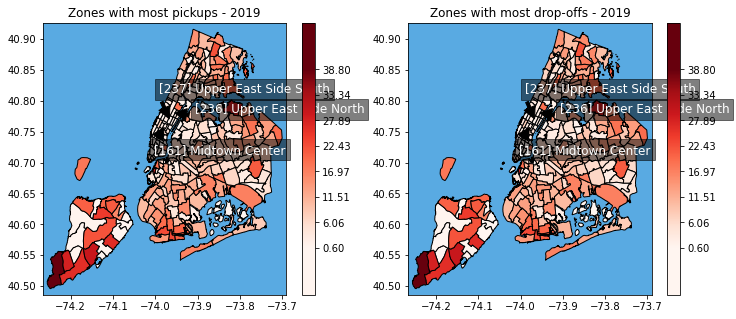

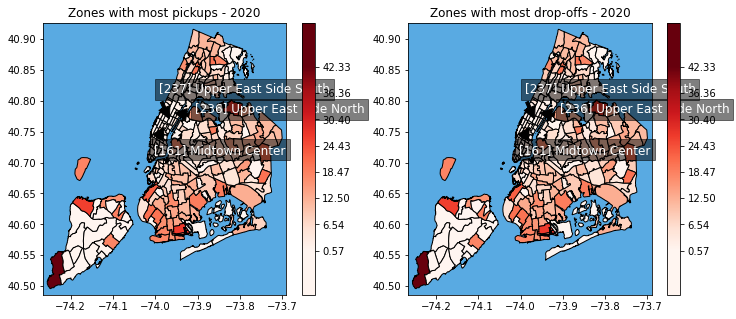

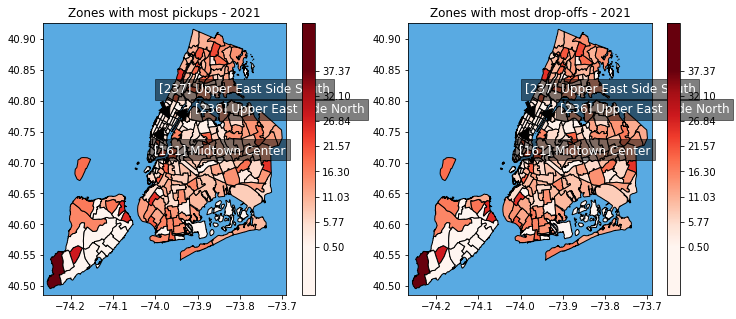

In [ ]:
for year in YEARS:
    PUcount = {k:v for k, v in top_do[top_do.year == year][['DOLocationID', 'trip_distance']].values}

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
    ax = plt.subplot(1, 2, 1)
    ax.set_title(f"Zones with most pickups - {year}")
    draw_zone_map(ax, sf, shp_dic, heat=PUcount, text=list(PUcount.keys())[:3])
    ax = plt.subplot(1, 2, 2)
    ax.set_title(f"Zones with most drop-offs - {year}")
    draw_zone_map(ax, sf, shp_dic, heat=PUcount, text=list(PUcount.keys())[:3])

**Pregunta: Per què creieu que la zona de Manhattan té més quantitat de viatges?**
> ANSWER: Perquè Manhattan és la zona que té més densitat de població.

## 07. Hospitals

Com ha canviat la destinació dels viatges? Hi ha més gent que va als hospitals?

A la següent cel·la us donem la creació manual d'un DataFrame amb la localització més important dels hospitals de Nova York.

In [ ]:
hospitals = [('New York’s Presbyterian Lower Manhattan Hospital, NYC, NY, USA', '40.710255', '-74.005058'),
('Manhattan Gastroenterology, NYC, NY, USA', '40.778259', '-73.958092'),
('Stem Cell Therapy Hospital, NYC, NY, USA', '40.601517', '-73.961067'),
('Park Avenue Smiles, Yonkers, NYC, NY, USA', '40.945873', '-73.890671'),
('Cosmetic Dentistry Center, NYC, NY, USA', '40.629234', '-74.026077'),
('Envy Smile Dental Spa, Brooklyn, NYC, NY, USA', '40.607059', '-73.960144'),
('VIVA EVE, Forest Hills, NYC, NY, USA', '40.734291', '-73.849434'),
('Forest Hills Medical Services, Queens, NYC, NY, USA', '40.734310', '-73.849510'),
('Professional Gynecological Services, Brooklyn, NY, NY, USA', '40.689747', '-73.982346'),
('Manhattan Womens Health & Wellness, New York, NY, USA', '40.741997', '-73.986107'),
('Brooklyn Abortion Clinic, Brooklyn, NY, New York, USA', '40.689743', '-73.982368'),
('Brooklyn GYN Place, Brooklyn, NY, USA', '40.692696', '-73.993584'),
('Americas Holistic Doctor, NYC, NY, USA', '40.742531', '-73.985489'),
('NJS Physical Medicine & Rehabilitation, Brooklyn, NY, USA', '40.641621', '-73.956734'),
('DHD Medical, Brooklyn New York, USA', '40.625568', '-73.918320'),
('Workers Compensation Doctor, New York, NY, USA', '40.652225', '-74.006104'),]

hospitals = pd.DataFrame(hospitals, columns = ['Place Name', 'Latitude', 'Longitude'])
hospitals['Latitude'] = hospitals['Latitude'].astype(float)
hospitals['Longitude'] = hospitals['Longitude'].astype(float)
hospitals.head()

,Place Name,Latitude,Longitude
0,New York’s Presbyterian Lower Manhattan Hospit...,40.710255,-74.005058
1,"Manhattan Gastroenterology, NYC, NY, USA",40.778259,-73.958092
2,"Stem Cell Therapy Hospital, NYC, NY, USA",40.601517,-73.961067
3,"Park Avenue Smiles, Yonkers, NYC, NY, USA",40.945873,-73.890671
4,"Cosmetic Dentistry Center, NYC, NY, USA",40.629234,-74.026077


In [ ]:
'''
En general, hi ha més viatges a les zones de l'hospital. Per tant, podem suposar que hi ha més gent que va a l'hospital
'''

"\nEn general, hi ha més viatges a les zones de l'hospital. Per tant, podem suposar que hi ha més gent que va a l'hospital\n"

In [ ]:
merge

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,total_amount,year,...,trip_duration,speed,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,longitude,latitude
0,2019-01-01 00:46:40,2019-01-01 00:53:20,1.0,1.50,151,239,1,7.0,9.95,2019,...,0.111111,13.500000,151,0.054890,0.000129,Manhattan Valley,151,Manhattan,-73.968222,40.797859
1,2019-01-01 01:13:52,2019-01-01 01:23:56,1.0,1.80,151,236,2,9.0,10.30,2019,...,0.167778,10.728477,151,0.054890,0.000129,Manhattan Valley,151,Manhattan,-73.968222,40.797859
2,2019-01-01 11:50:47,2019-01-01 11:59:38,1.0,1.76,151,142,2,8.5,9.30,2019,...,0.147500,11.932203,151,0.054890,0.000129,Manhattan Valley,151,Manhattan,-73.968222,40.797859
3,2019-01-01 14:39:57,2019-01-01 14:47:33,6.0,1.57,151,41,2,8.0,8.80,2019,...,0.126667,12.394737,151,0.054890,0.000129,Manhattan Valley,151,Manhattan,-73.968222,40.797859
4,2019-01-01 17:23:52,2019-01-01 17:28:16,1.0,0.80,151,238,1,5.5,7.25,2019,...,0.073333,10.909091,151,0.054890,0.000129,Manhattan Valley,151,Manhattan,-73.968222,40.797859
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126304,2020-11-11 01:15:29,2020-11-11 02:08:22,1.0,42.33,86,44,1,111.5,127.79,2020,...,0.881389,48.026473,86,0.134245,0.000623,Far Rockaway,86,Queens,-73.755904,40.602582
126305,2021-12-30 19:43:14,2021-12-30 20:41:34,1.0,10.60,86,28,1,31.2,32.00,2021,...,0.972222,10.902857,86,0.134245,0.000623,Far Rockaway,86,Queens,-73.755904,40.602582
126306,2021-01-14 06:40:36,2021-01-14 07:39:29,1.0,34.89,99,95,1,96.0,99.55,2021,...,0.981389,35.551656,99,0.183371,0.001210,Freshkills Park,99,Staten Island,-74.188371,40.579422
126307,2021-09-27 23:49:15,2021-09-28 00:08:02,1.0,11.07,183,64,1,32.0,33.30,2021,...,0.313056,35.361136,183,0.039826,0.000095,Pelham Bay,183,Bronx,-73.831501,40.849546


Utilitza la latitud i longitud de cada hospital i la de les zones del dataframe *merge* per veure la distribució dels hospitals.

Per fer-ho utilitza els gràfics de dispersió. Recorda que s'entendrà millor si els punts són transparents (paràmetre *alpha*).

Després repeteix el mateix gràfic però separat per any. 

In [ ]:
def scatter_locations(merge, hospitals):
    """Funció que mostra la distribució dels hospitals i les destinacions dels taxis"""

    # obtenir la latitud i longitud dels hospitals i de la taula merge
    hospital_x = hospitals['Latitude']
    hospital_y = hospitals['Longitude']
    merge_x = merge['latitude']
    merge_y = merge['longitude']

    # representar un gràfic de dispersió amb les latituds i longituds que hem obtinguts
    plt.scatter(merge_x, merge_y, alpha=0.3,color='red', cmap='viridis')
    plt.scatter(hospital_x,hospital_y, alpha=0.7,color='blue', cmap='viridis')
    plt.colorbar()
    plt.legend(['zones','hospitals'])

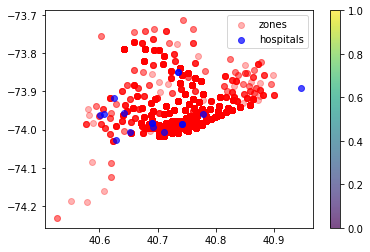

In [ ]:
scatter_locations(merge, hospitals)

In [ ]:
def scatter_locations_per_year(merge, hospitals):
    """Funció que mostra la distribució dels hospitals i les destinacions dels taxis"""

    fig, axs = plt.subplots(nrows =1,ncols=3,figsize=(20,10))

    # obtenir la latitud i longitud dels hospitals i de la taula merge
    hospital_x = hospitals['Latitude']
    hospital_y = hospitals['Longitude']

    # representar 3 gràfic per cada any
    for y in YEARS:

        # seleccionar les dades d'aquest any i obtenir la latitud i longitud
        new_merge = merge.loc[merge['year']==y]
        merge_x = new_merge['latitude']
        merge_y = new_merge['longitude']

        # representa el gràfic de dispersió
        axs[y-2019].set_xlabel("latitude")
        axs[y-2019].set_ylabel("longitude")
        axs[y-2019].set_title("gràfic de dispersió "f'{y}')
        im = axs[y-2019].scatter(merge_x, merge_y, alpha=0.3,color='red', cmap='viridis')
        axs[y-2019].scatter(hospital_x,hospital_y, alpha=0.7,color='blue', cmap='viridis')
        axs[y-2019].legend(['zones','hospitals'])
        plt.colorbar(im,ax=axs[y-2019])

    plt.show()




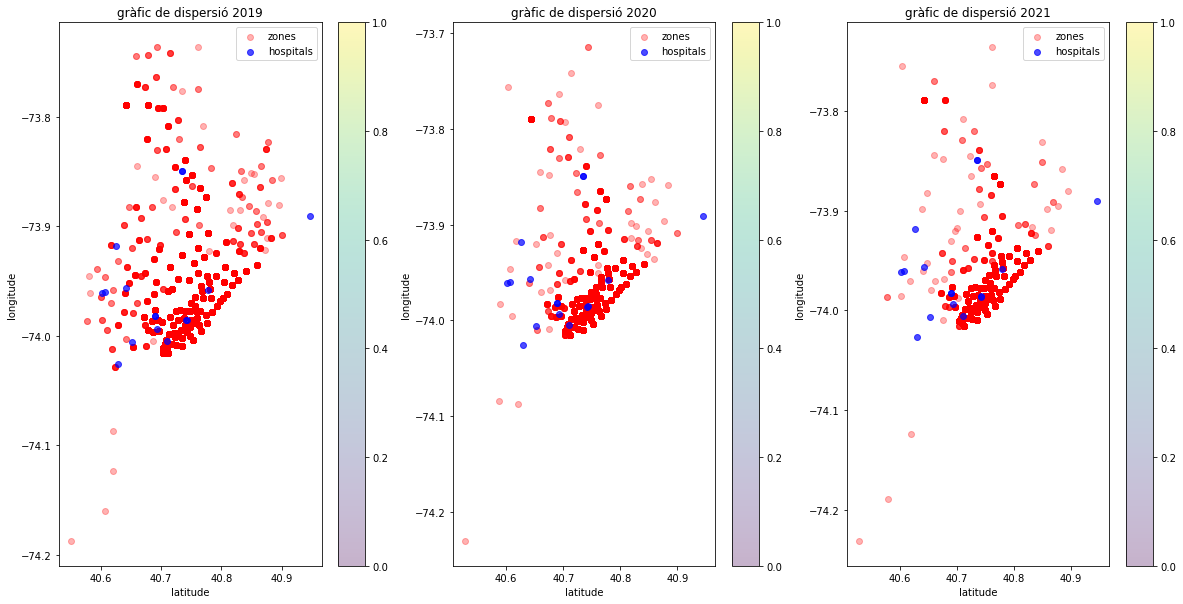

In [ ]:
scatter_locations_per_year(merge, hospitals)

**Pregunta: Veus algun comportament?**
>ANSWER: En general, la majoria de les hospitals estan situades a les zones on hi ha més viatges.

Per poder conèixer com ha variat els trajectes als hospitals, primer cal detectar a quina localització del mapa pertany cada hospital.

Per fer això cal calcular les distàncies. No calculeu la distància punt a punt, sinó matricialment.

In [ ]:
from scipy.spatial import distance_matrix

In [ ]:
hospitals_loc = hospitals[['Longitude', 'Latitude']].values
loc = df_loc[['longitude', 'latitude']].values

# el variable dist gaurda la matriu de les distancies entre cadascú de les zones amb cada hospital
dist = distance_matrix(hospitals_loc,loc)

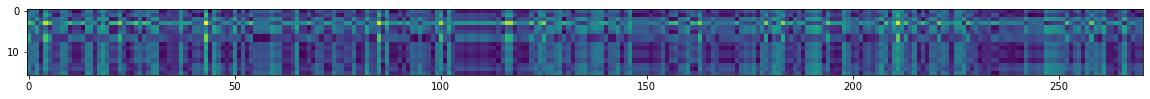

In [ ]:
plt.figure(figsize=(20, 5))
plt.imshow(dist)

Trobeu la manera de localitzar el sector més proper a partir de les distàncies.

In [ ]:
# AQUÍ EL TEU CODI
# l'eix x = localitats de hospitals, l'eix y = localitats de les zones
# Per obtenir el sector més proper a partir de 'dist' hem de calcular els valors mínims de cada fila, ja que és la distancia entre hospital i les zones
# podem veure que en la taula df_loc la LocationID és index + 1
# per tant, calculem els indexos dels valors mínims de cada fila, ja que cada fila del matriu 'dist' és la distancia de les localitats amb 1 hospital en concret. I suma 1 al vector per obtenir LocationID
hospitals_locations = np.argmin(dist,axis=1) + 1

# crear una nova columna amb LocationID corresponent
hospitals['LocationID'] = hospitals_locations

In [ ]:
hospitals.head()

,Place Name,Latitude,Longitude,LocationID
0,New York’s Presbyterian Lower Manhattan Hospit...,40.710255,-74.005058,217
1,"Manhattan Gastroenterology, NYC, NY, USA",40.778259,-73.958092,244
2,"Stem Cell Therapy Hospital, NYC, NY, USA",40.601517,-73.961067,131
3,"Park Avenue Smiles, Yonkers, NYC, NY, USA",40.945873,-73.890671,208
4,"Cosmetic Dentistry Center, NYC, NY, USA",40.629234,-74.026077,14


Ara que ja tenim en quin sector es troben els hospitals, visualitzeu quants trajectes hi ha relacionats amb ells.

Suposarem que tots els trajectes al sector van a l'hospital.

Feu una única figura amb dos gràfics de barres on es mostrin la quantitat de viatges per cada any i el % del total dels viatges.

In [ ]:
def trips_hospitals(df, hospitals_locations):
    """
    Funció que mostra una única figura amb dos gràfics de barres on es mostrin la quantitat de viatges per cada any i el % del total dels viatges.
    """
    # AQUÍ EL TEU CODI
    # seleccionem dins del df només les files on DOLocationID existeix a dintre del sector dels hospitals, ja que ha de tenir el mateix sector per anar a l'hospital
    trajectesHospitals = df[df.DOLocationID.isin(hospitals_locations)]

    # agrupar per any i contar els viatges
    trajectesHospitals = trajectesHospitals.groupby('year').agg(total_trips=('DOLocationID', 'count')).reset_index()
    
    fig, axs = plt.subplots(1,2,figsize = (20,15))

    # la primera gràfica de barres es mostra la quantitat de viatges per cada any
    trajectesHospitals['total_trips'].plot(ax=axs[0],xlabel='Anys',ylabel="Quantitat",title='Quantitat de viatges per any',kind='bar')
    axs[0].set_xticklabels(trajectesHospitals['year'].unique(),rotation='horizontal')


    # la segona gràfica de barres es mostra la quantitat de viatges en tant per cent per cada any
    viatges_total = trajectesHospitals['total_trips'].sum()
    trajectesHospitals['total_trips_percentage'] = trajectesHospitals['total_trips'] / viatges_total
    trajectesHospitals['total_trips_percentage'].plot(ax=axs[1],xlabel='Anys',ylabel="Quantitat en %",title='Quantitat de viatges per any',kind='bar')
    axs[1].set_xticklabels(trajectesHospitals['year'].unique(),rotation='horizontal')
    plt.show()



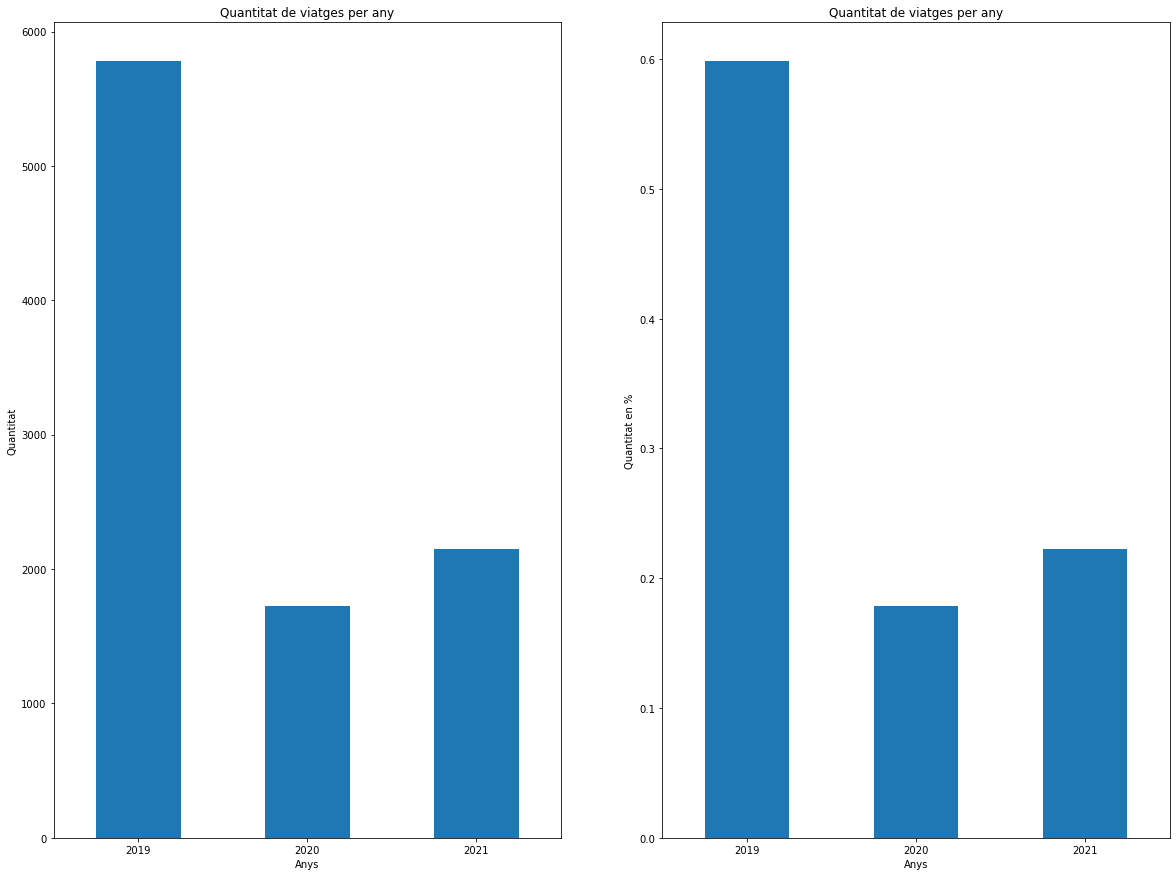

In [ ]:
trips_hospitals(df, hospitals_locations)

## 08. Qui escolta pels forats, sent els seus pecats

A la **primera part** heu de visualitzar i comentar els exemples que hem eliminat, com distancies molt llargues, molt curtes...

A la **segona part** teniu llibertat per escollir i fer visualitzacions que us aportin informació extra que no s'hagi vist anteriorment.

In [ ]:
'''

primera part

'''
required_data = ['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance', 'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'total_amount']

# variables de limits per netejar les dades
minimal_distance = 0.5 #equival 500 meters
maximal_distance = 50 #equival 50 km
minimal_passenger_count = 1
maximal_passenger_count = 9

def invalidDates(data, year, month, sampling = 1000):

    if sampling != None:
        data = data[::sampling]

    # condicions per netejar les dades invalids
    filt1 = (data['tpep_pickup_datetime'] < data['tpep_dropoff_datetime'])
    filt2 = (pd.DatetimeIndex(data['tpep_pickup_datetime']).year == year)
    filt3 = (data['passenger_count'] >= minimal_passenger_count)
    filt4 = (data['passenger_count'] <= maximal_passenger_count)
    filt5 = (data['trip_distance'] >= minimal_distance)
    filt6 = (data['trip_distance'] <= maximal_distance)
    filt7 = (data['total_amount'] > 0) 

    # en aquest cas necessitem les dades invàlides per tant utilitzem el signe ~ per obtenir les dades
    data = data.loc[~(filt1 & filt2 & filt3 & filt4 & filt5 & filt6 & filt7)]
    
    return(data[required_data].drop_duplicates())



    '''
    Podem veure que en aquesta taula ens mostra les exemples que compleix una de les condicions següents:
        1. la data de pickup més tard que la data de drop off
        2. els anys no ha de estar entre 2019 i 2021
        3. el nombre de passatgers no ha de ser més o igual que 1 ni més petit o igual que 9
        4. la distancia del viatge que són més petit que 0.5km, ja que considerem que un viatge de 500 metres és massa curt
        5. la distancia del viatge que són més gran que 50km, ja que considerem que és un viatge massa llarg
        6. el total de diners pagat és negatiu, ja que un pagament negatiu no és vàlid

    '''


In [ ]:
invalidDatesTable = pd.concat([invalidDates(load_table(year, month), year, month) for year in tqdm(YEARS) for month in tqdm(range(1, 13), leave = False)])

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

In [ ]:
invalidDatesTable

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,total_amount
10000,2019-01-01 00:24:57,2019-01-01 00:30:03,1.0,0.44,113,234,2,5.00,6.30
19000,2019-01-01 01:55:33,2019-01-01 01:56:16,1.0,0.00,141,141,1,2.50,4.90
35000,2019-01-01 02:37:47,2019-01-01 02:43:10,1.0,0.26,164,161,2,5.00,6.30
81000,2019-01-01 11:06:14,2019-01-01 11:10:52,0.0,1.10,140,236,3,6.00,6.80
97000,2019-01-01 13:23:10,2019-01-01 13:25:25,1.0,0.21,211,144,2,3.50,4.30
...,...,...,...,...,...,...,...,...,...
3210000,2021-12-29 10:44:00,2021-12-29 10:56:00,NaN,3.97,262,107,0,16.41,23.93
3211000,2021-12-29 22:56:54,2021-12-29 23:07:29,NaN,1.40,163,162,0,8.50,14.15
3212000,2021-12-30 15:56:00,2021-12-30 16:26:00,NaN,5.67,186,74,0,28.73,38.99
3213000,2021-12-31 10:43:08,2021-12-31 10:48:40,NaN,1.43,263,162,0,13.20,19.13


In [215]:
'''

Segona part

    En aquest part visualitzarem els quantitat de diners guanyats per cada any per veure clarament l'afectació de covid a la taxi de Nova York.
    Els visualitzem per gràfic de barres i per una histograma.

'''

def TotalAmountVisulitzation(df):

    '''
    Funció que mostra el gràfic de barra del quantitat de diners guanyats per cada any
    '''
    # agrupar per any la quantitat de diners guanyats i sumar la quantitat de cada any
    totalAmount = df.groupby('year').agg(totalAmountYear=('total_amount', 'sum')).reset_index()

    # la primera gràfica de barres es mostra la quantitat de viatges per cada any
    totalAmount['totalAmountYear'].plot(xlabel='Anys',ylabel="Quantitat",title='Quantitat de diners guanyats per any',kind='bar')
    
    plt.xticks(ticks=[0,1,2],labels=totalAmount['year'].unique(),rotation='horizontal')



def AmountHistogram(df,column,title,xlabel,ylabel):

    '''
    Funció que mostra el gràfic de de histograma del quantitat de diners guanyats per cada any
    '''
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 8)) 

    # representar la gràfica per cada any
    for i in YEARS:

        # selecciona les dades d'aquest any
        new_df = df.loc[df['year'] == i, column]

        # representar la histograma
        new_df.hist(bins=75, ax=axs[i-2019])
        axs[i-2019].set_title(title + f" ({i})")
        axs[i-2019].set_xlabel(xlabel)
        axs[i-2019].set_ylabel(ylabel)
    

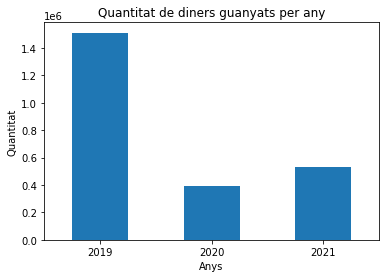

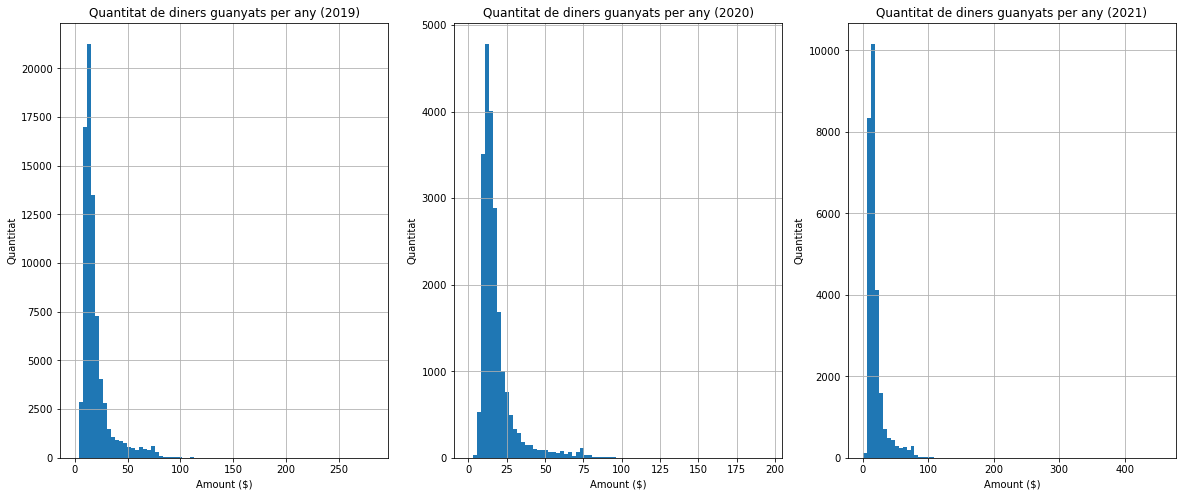

In [216]:
TotalAmountVisulitzation(df)


AmountHistogram(df,'total_amount',title='Quantitat de diners guanyats per any',xlabel='Amount ($)',ylabel='Quantitat')

## 09. Informe

A partir de l'exploració de les dades que heu fet al llarg d'aquest notebook, feu un petit informe resumint i justificant tots els canvis que han sorgit a causa de la covid.

In [ ]:
'''
Introducció:
    En aquesta pràctica aplicarem les libreries Numpy i Pandas per fer una cerca de com la pandèmia de covid ha afectat als taxis de Nava York.

En primer lloc hem de netejar aquells dades que no són valides. Després hem visualitzat la quantitat de viatges en els 3 anys (2019, 2020 i 2021) i obtenim la conclusió de que la covid ha afectat
bastant sobre els viatges de taxis, ja que podem veure que en el 2019 (abans de pandèmia) hi ha molta quantitat de viatges i en canvi, en el 2020 i 2021 (amb pandèmia) la quantitat de viatges 
ha decrementat molt tant representat per hora o per dia. 

Podem veure en les histogrames que en els viatges de curta durada la covid no s'afecta gaire, en canvi, en les viatges de distància mitjana la covid fa que el nombre de viatges es disminueixen. 
En en cas de durades del viatges passa el mateix, no es veu l'afectació del covid en curta durada sinó afecta més en llargues durades. 

En el gràfic de dispersió mostra que la majoria dels viatges són de curta durada sobretot en el període de pandèmia.

La zona on hi ha més viatges és la Manhattan i podem veure en el gràfic de dispersió que en general els hospitals està a les zones on hi ha més viatges. També en el map de calor es mostra la 
relació entre les distancies i els hospitals.


Em conclusió:
    En aquesta pràctica hem après d'utilitzar pandas i numpy per visualitzar taules i modificar-les i finalment hem obtingut la conclusió de que la pandèmia de covid ha afectat bastant en 
    els taxis de Nova York.

'''

"\nIntroducció:\n    En aquesta pràctica aplicarem les libreries Numpy i Pandas per fer una cerca de com la pandèmia de covid ha afectat als taxis de Nava York.\n\nEn primer lloc hem de netejar aquells dades que no són valides. Després hem visualitzat la quantitat de viatges en els 3 anys (2019, 2020 i 2021) i obtenim la conclusió de que la covid ha afectat\nbastant sobre els viatges de taxis, ja que podem veure que en el 2019 (abans de pandèmia) hi ha molta quantitat de viatges i en canvi, en el 2020 i 2021 (amb pandèmia) la quantitat de viatges \nha decrementat molt tant representat per hora o per dia. \n\nPodem veure en les histogrames que en els viatges de curta durada la covid no s'afecta gaire, en canvi, en les viatges de distància mitjana la covid fa que el nombre de viatges es disminueixen. \nEn en cas de durades del viatges passa el mateix, no es veu l'afectació del covid en curta durada sinó afecta més en llargues durades. \n\nEn el gràfic de dispersió mostra que la majoria d